Combined dataset size: 7798424 events


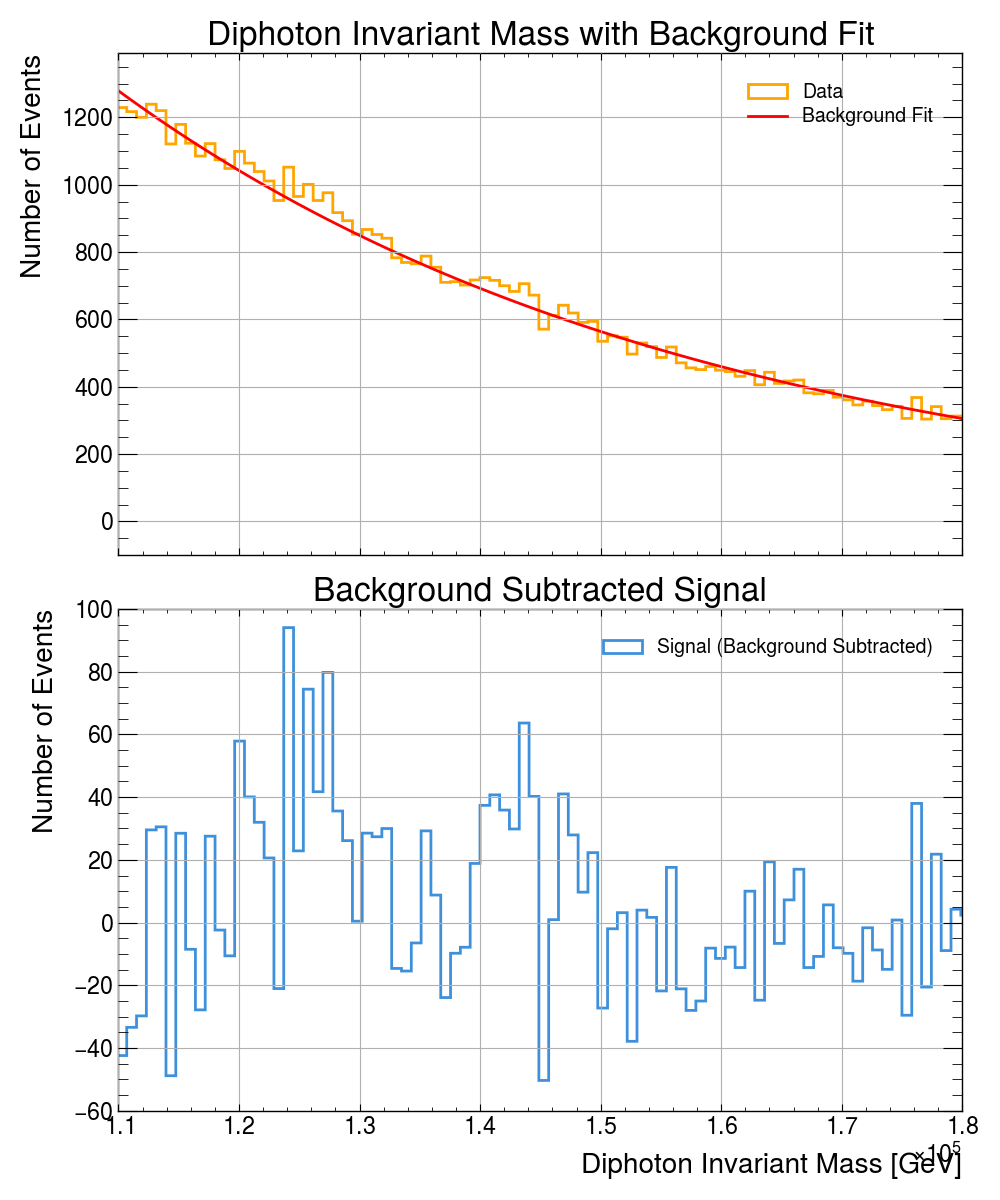

Signal events (S): 504.45562434259955
Background events (B): 12271.544375657399
Higgs signal significance: 4.55 sigma
Second signal significance: 3.45 sigma
photon_pt_threshold: 40000


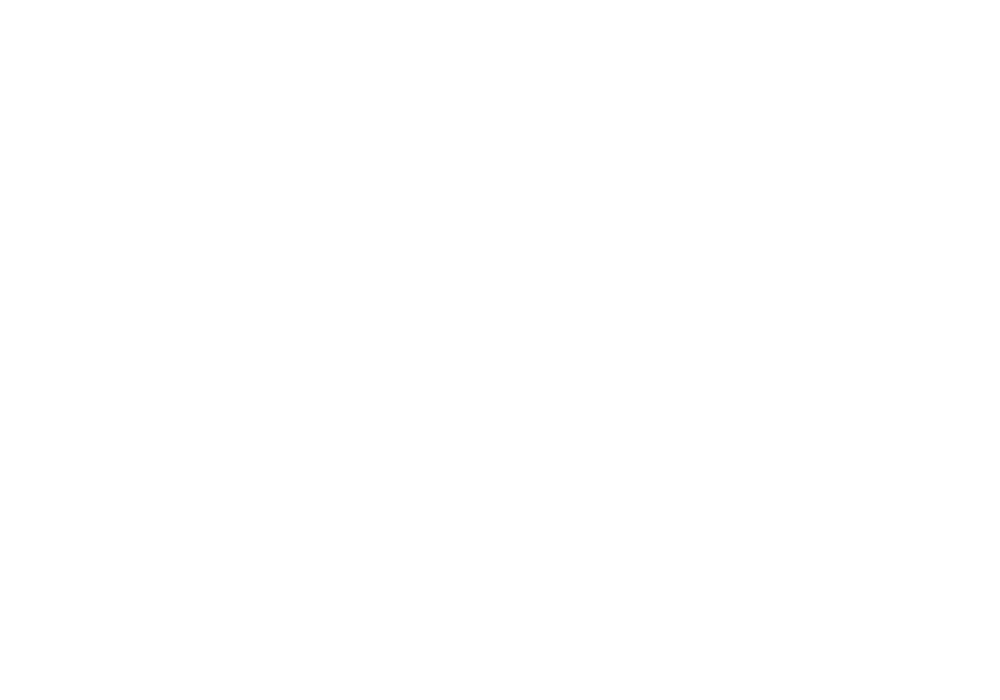

In [87]:
%matplotlib widget
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import vector


multiple_files = True


if multiple_files == True:
    # List of ROOT files
    root_files = [
        "C:/Users/fuell/Larissa/Studienstiftung/Akademie Annecy/Daten CERN/GamGam/Data/data_A.GamGam.root",
        "C:/Users/fuell/Larissa/Studienstiftung/Akademie Annecy/Daten CERN/GamGam/Data/data_B.GamGam.root",
        "C:/Users/fuell/Larissa/Studienstiftung/Akademie Annecy/Daten CERN/GamGam/Data/data_C.GamGam.root",
        "C:/Users/fuell/Larissa/Studienstiftung/Akademie Annecy/Daten CERN/GamGam/Data/data_D.GamGam.root"
    ]

    # Initialize empty lists to store data from all files
    all_photon_pt = []
    all_photon_eta = []
    all_photon_phi = []
    all_photon_E = []
    all_photon_isTightID = []
    all_photon_isolation = []
    all_jet_pt = []
    all_jet_eta = []

    # Loop over each file and extract data
    for file in root_files:
        root_file = uproot.open(file)
        tree = root_file["mini"]
        
        # Append data to the lists
        all_photon_pt.append(tree["photon_pt"].array(library="np"))
        all_photon_eta.append(tree["photon_eta"].array(library="np"))
        all_photon_phi.append(tree["photon_phi"].array(library="np"))
        all_photon_E.append(tree["photon_E"].array(library="np"))
        all_photon_isTightID.append(tree["photon_isTightID"].array(library="np"))
        all_photon_isolation.append(tree["photon_etcone20"].array(library="np"))
        all_jet_pt.append(tree["jet_pt"].array(library="np"))
        all_jet_eta.append(tree["jet_eta"].array(library="np") 
)

    # Concatenate all arrays into one dataset for each variable
    photon_pt = np.concatenate(all_photon_pt)
    photon_eta = np.concatenate(all_photon_eta)
    photon_phi = np.concatenate(all_photon_phi)
    photon_E = np.concatenate(all_photon_E)
    photon_isTightID = np.concatenate(all_photon_isTightID)
    photon_isolation = np.concatenate(all_photon_isolation)
    jet_pt = np.concatenate(all_jet_pt)
    jet_eta = np.concatenate(all_jet_eta)
    

    # Now photon_pt, photon_eta, photon_phi, photon_E, photon_isTightID, photon_isolation, and jet_pt contain data from all files
    number_events_input = len(photon_pt)


if multiple_files == False:
    # Load the ROOT file and the tree
    file = uproot.open("C:/Users/fuell/Larissa/Studienstiftung/Akademie Annecy/Daten CERN/GamGam/Data/data_B.GamGam.root")  # replace with the correct path
    tree = file["mini"]



    # Extract photon and jet information
    photon_pt = tree["photon_pt"].array(library="np")
    photon_eta = tree["photon_eta"].array(library="np")
    photon_phi = tree["photon_phi"].array(library="np")
    photon_E = tree["photon_E"].array(library="np")
    photon_isTightID = tree["photon_isTightID"].array(library="np")  # Assuming tight photon ID is available
    photon_isolation = tree["photon_etcone20"].array(library="np")  # Assuming isolation variable is available
    jet_pt = tree["jet_pt"].array(library="np")  # Assuming the tree has jet information
    jet_eta = tree["jet_eta"].array(library="np") 

    number_events_input = len(photon_pt)


print(f"Combined dataset size: {number_events_input} events")


# Event selection
photon_pt_threshold = 40000  # 40 GeV
photon_isolation_threshold = 3000
jet_pt_threshold = 30000
photon_eta_threshold = 2.37
large_jet_eta_separation = 3.0


# Prepare arrays for invariant masses and categories
masses = []
categories = []

for event in range(len(photon_pt)):
    sorted_indices = np.argsort(photon_pt[event])[::-1]  # Sort photon transverse momenta in descending order
    
    # Photon pT Cuts
    if photon_pt[event][sorted_indices[0]] < photon_pt_threshold or photon_pt[event][sorted_indices[1]] < photon_pt_threshold:
        continue  # Skip this event if either photon doesn't pass the pT cut
    
    # Photon ID and Isolation Cuts
    if not photon_isTightID[event][sorted_indices[0]] or not photon_isTightID[event][sorted_indices[1]]:
        continue  # Skip if either photon does not pass the tight ID criteria
    
    if photon_isolation[event][sorted_indices[0]] > photon_isolation_threshold or photon_isolation[event][sorted_indices[1]] > photon_isolation_threshold:
        continue  # Skip if either photon fails the isolation cut
    
    # Pseudorapidity (Eta) Cuts
    if abs(photon_eta[event][sorted_indices[0]]) > photon_eta_threshold or abs(photon_eta[event][sorted_indices[1]]) > photon_eta_threshold:
        continue  # Skip if either photon is outside the acceptable eta range
    
    # Create four-momentum vectors for the two photons
    pt1, pt2 = photon_pt[event][sorted_indices[0]], photon_pt[event][sorted_indices[1]]
    eta1, eta2 = photon_eta[event][sorted_indices[0]], photon_eta[event][sorted_indices[1]]
    phi1, phi2 = photon_phi[event][sorted_indices[0]], photon_phi[event][sorted_indices[1]]
    E1, E2 = photon_E[event][sorted_indices[0]], photon_E[event][sorted_indices[1]]
    photon1 = vector.obj(px=pt1 * np.cos(phi1), py=pt1 * np.sin(phi1), pz=pt1 * np.sinh(eta1), E=E1)
    photon2 = vector.obj(px=pt2 * np.cos(phi2), py=pt2 * np.sin(phi2), pz=pt2 * np.sinh(eta2), E=E2)
    
    # Calculate the invariant mass
    mass = (photon1 + photon2).mass
    
    # Jet Veto or VBF Category
    if any(jet > jet_pt_threshold for jet in jet_pt[event]):
        if len(jet_pt[event]) >= 2:
            jet1_pt, jet2_pt = jet_pt[event][0], jet_pt[event][1]
            if jet1_pt > 30000 and jet2_pt > 30000:
                delta_eta = abs(jet_eta[event][0] - jet_eta[event][1])
                if delta_eta > large_jet_eta_separation:
                    # VBF-like category
                    categories.append('VBF')
                else:
                    continue  # Veto non-VBF jets
        else:
            continue  # Jet veto for non-VBF events
    
    masses.append(mass)



Plot

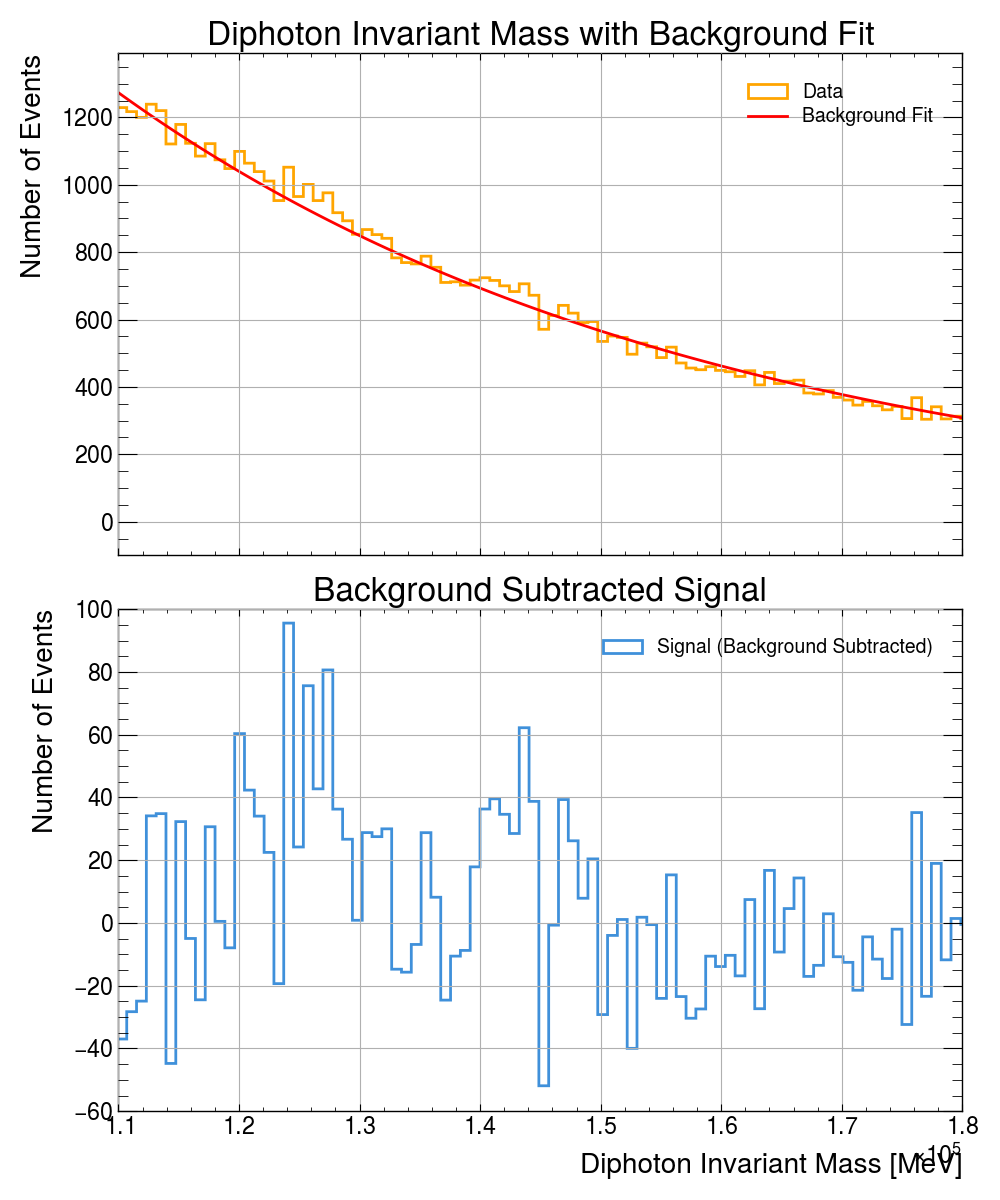

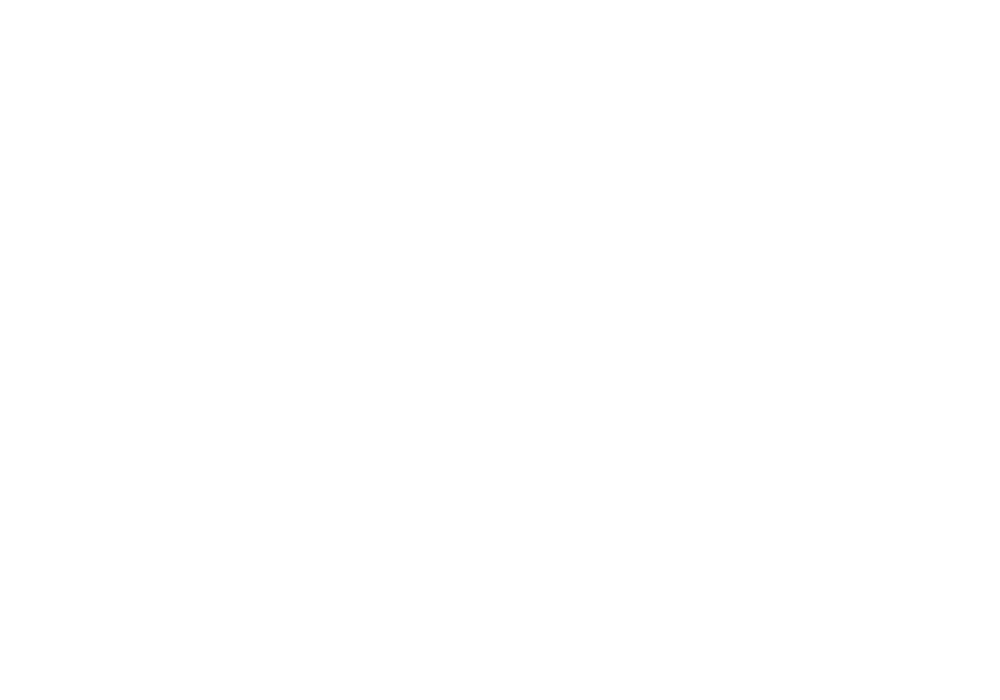

In [88]:
# Plotting the invariant mass distribution
plt.figure(figsize=(10, 7))
hist, bins, _ = plt.hist(masses, bins=3000, histtype='step', linewidth=2, label="Data")
bin_centers = (bins[:-1] + bins[1:]) / 2



# Define an exponential function for the background
def poly_background(x, a, b):
    return a * np.exp(b * x) 

param_a = 3500
param_b = 1/100000

# Fit the background in a sideband region (excluding the signal region)
sideband_mask = ((bin_centers > 1.1e5) & (bin_centers < 1.2e5)) | ((bin_centers > 1.3e5) & (bin_centers < 3.0e5)) # Exclude 115-135 GeV region
popt, _ = curve_fit(poly_background, bin_centers[sideband_mask], hist[sideband_mask], p0=(param_a, param_b))

#sideband_mask = (bin_centers > 9e4) & (bin_centers < 2e5)  # Exclude 115-135 GeV region
#popt, _ = curve_fit(poly_background, bin_centers[sideband_mask], hist[sideband_mask], p0=(param_a, param_b))

# Calculate the background across the entire range
background = poly_background(bin_centers, *popt)

# Subtract the background from the original histogram
signal = hist - background



plt.clf()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Signal + Background fit
ax1.hist(bin_centers, bins=bins, weights=hist, histtype='step', linewidth=2, label="Data", color="orange")
ax1.plot(bin_centers, background, 'r-', label="Background Fit", linewidth=2)
ax1.set_ylabel("Number of Events")
ax1.set_title("Diphoton Invariant Mass with Background Fit")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(-100, max(hist)+50)

# Subplot 2: Background Subtracted Signal
ax2.hist(bin_centers, bins=bins, weights=signal, histtype='step', linewidth=2, label="Signal (Background Subtracted)")
ax2.set_xlabel("Diphoton Invariant Mass [MeV]")
ax2.set_ylabel("Number of Events")
ax2.set_title("Background Subtracted Signal")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-60, 100)

# Apply ATLAS style for both plots
hep.style.use("ATLAS")

plt.xlim(1.1e5, 1.8e5)
plt.tight_layout()
plt.show()


Signifikanzberechnung

In [ ]:

# Significance of Higgs peak
# Define the signal region around the Higgs mass peak
signal_region_min = 120000  # 120 GeV in MeV
signal_region_max = 130000  # 130 GeV in MeV

# Find the bins that correspond to the signal region
signal_region_mask = (bin_centers > signal_region_min) & (bin_centers < signal_region_max)

# Calculate the number of signal events (background-subtracted events in the signal region)
S = np.sum(signal[signal_region_mask])

# Calculate the number of background events (using the background function in the signal region)
B = np.sum(background[signal_region_mask])

# Calculate the significance using the formula S / sqrt(B)
if B > 0:
    significance = S / np.sqrt(B)
else:
    significance = 0  # Avoid division by zero


# Significance of second peak

# Define the signal region around the Higgs mass peak
signal_region_min_2 = 140000  # 120 GeV in MeV
signal_region_max_2 = 150000  # 130 GeV in MeV

# Find the bins that correspond to the signal region
signal_region_mask_2 = (bin_centers > signal_region_min_2) & (bin_centers < signal_region_max_2)

# Calculate the number of signal events (background-subtracted events in the signal region)
S_2 = np.sum(signal[signal_region_mask_2])

# Calculate the number of background events (using the background function in the signal region)
B_2 = np.sum(background[signal_region_mask_2])

# Calculate the significance using the formula S / sqrt(B)
if B_2 > 0:
    significance_2 = S_2 / np.sqrt(B_2)
else:
    significance_2 = 0  # Avoid division by zero

print(f"Signal events (S): {S}")
print(f"Background events (B): {B}")
print(f"Higgs signal significance: {significance:.2f} sigma")
print(f"Second signal significance: {significance_2:.2f} sigma")
print(f"photon_pt_threshold: {photon_pt_threshold}")

Plot mit Gauss

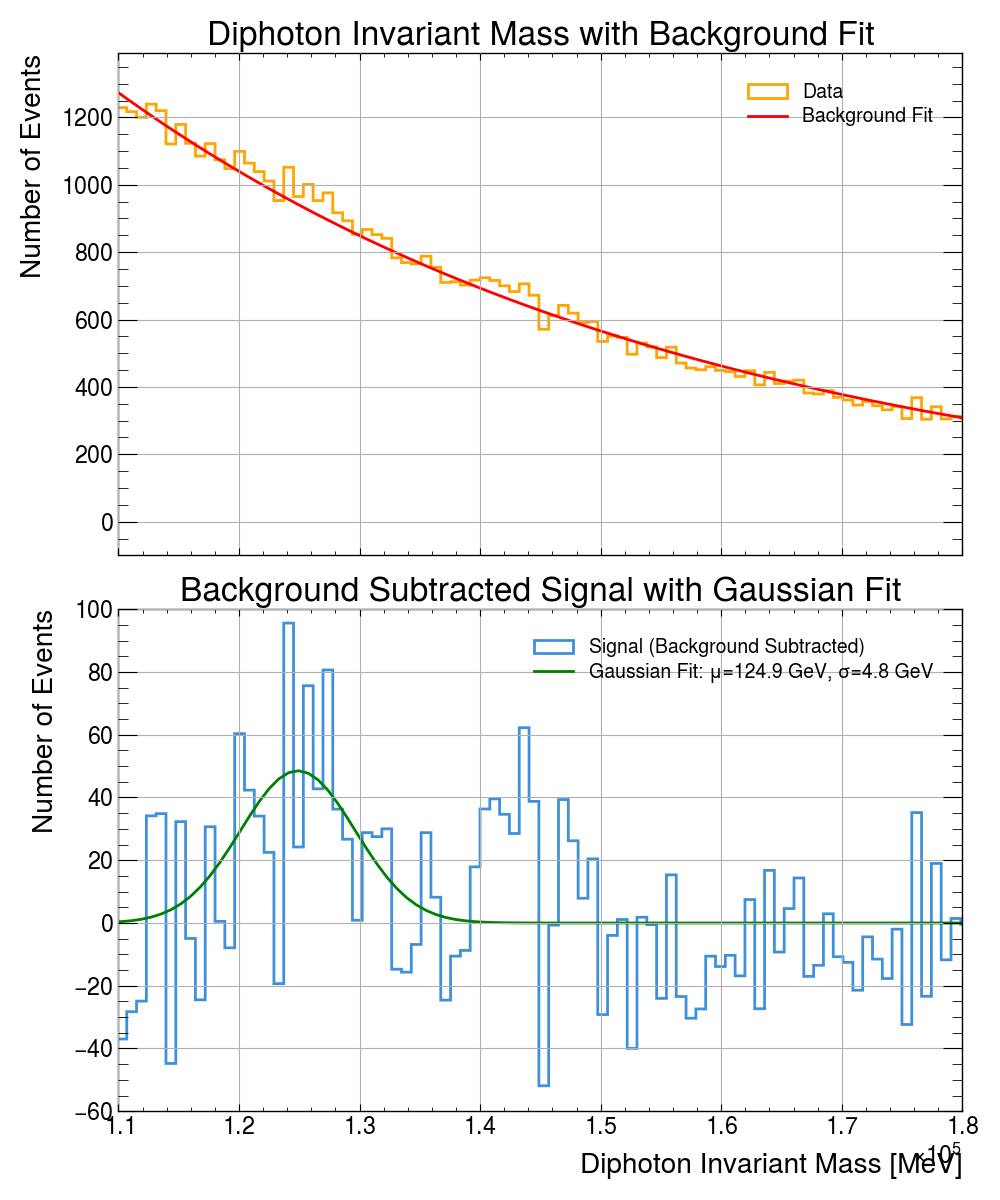

Gaussian amplitude: 48.522935813211156
Gaussian mean (center): 124.9 GeV
Gaussian sigma (width): 4.8 GeV


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mplhep as hep

# Define an exponential function for the background
def poly_background(x, a, b):
    return a * np.exp(b * x) 

# Define a Gaussian function for the signal peak
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# Fit the background in a sideband region (excluding the signal region)
sideband_mask = ((bin_centers > 1.1e5) & (bin_centers < 1.2e5)) | ((bin_centers > 1.3e5) & (bin_centers < 3.0e5))
popt_background, _ = curve_fit(poly_background, bin_centers[sideband_mask], hist[sideband_mask], p0=(3500, 1/100000))

# Calculate the background across the entire range
background = poly_background(bin_centers, *popt_background)

# Subtract the background from the original histogram to isolate the signal
signal = hist - background

# Fit a Gaussian to the signal in the region around 125 GeV (120-130 GeV)
signal_region_mask = (bin_centers > 1.2e5) & (bin_centers < 1.3e5)
popt_gaussian, _ = curve_fit(gaussian, bin_centers[signal_region_mask], signal[signal_region_mask], p0=[100, 1.25e5, 2e3])

# Extract fitted Gaussian parameters
amp, mean, sigma = popt_gaussian

# Generate Gaussian curve using the fitted parameters
gaussian_fit = gaussian(bin_centers, *popt_gaussian)

plt.clf()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Signal + Background fit
ax1.hist(bin_centers, bins=bins, weights=hist, histtype='step', linewidth=2, label="Data", color="orange")
ax1.plot(bin_centers, background, 'r-', label="Background Fit", linewidth=2)
ax1.set_ylabel("Number of Events")
ax1.set_title("Diphoton Invariant Mass with Background Fit")
ax1.legend()
ax1.grid(True)
ax1.set_ylim(-100, max(hist)+50)

# Subplot 2: Background Subtracted Signal with Gaussian Fit
ax2.hist(bin_centers, bins=bins, weights=signal, histtype='step', linewidth=2, label="Signal (Background Subtracted)")
ax2.plot(bin_centers, gaussian_fit, 'g-', label=f"Gaussian Fit: μ={mean/1e3:.1f} GeV, σ={sigma/1e3:.1f} GeV", linewidth=2)
ax2.set_xlabel("Diphoton Invariant Mass [MeV]")
ax2.set_ylabel("Number of Events")
ax2.set_title("Background Subtracted Signal with Gaussian Fit")
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-60, 100)

# Apply ATLAS style for both plots
hep.style.use("ATLAS")

plt.xlim(1.1e5, 1.8e5)
plt.tight_layout()
plt.show()

# Output Gaussian fit parameters
print(f"Gaussian amplitude: {amp}")
print(f"Gaussian mean (center): {mean/1e3:.1f} GeV")
print(f"Gaussian sigma (width): {sigma/1e3:.1f} GeV")
